### Boosted Ensembles 

Continuing on with our work with classifiers and ensembles today we introduce boosted models, a powerful collection of tree based models that learn in sequence.  

In [99]:
# !pip install xgboost

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

### Gradient Boosted Models

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Ensemble_Boosting.svg/2880px-Ensemble_Boosting.svg.png)

In [157]:
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.datasets import fetch_california_housing, load_breast_cancer
from sklearn.datasets import fetch_openml

In [160]:
bikes = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True).frame

In [161]:
bikes.head()

season  year  month  hour  ... feel_temp  humidity windspeed count
0  spring     0      1     0  ...    14.395      0.81       0.0    16
1  spring     0      1     1  ...    13.635      0.80       0.0    40
2  spring     0      1     2  ...    13.635      0.80       0.0    32
3  spring     0      1     3  ...    14.395      0.75       0.0    13
4  spring     0      1     4  ...    14.395      0.75       0.0     1

[5 rows x 13 columns]

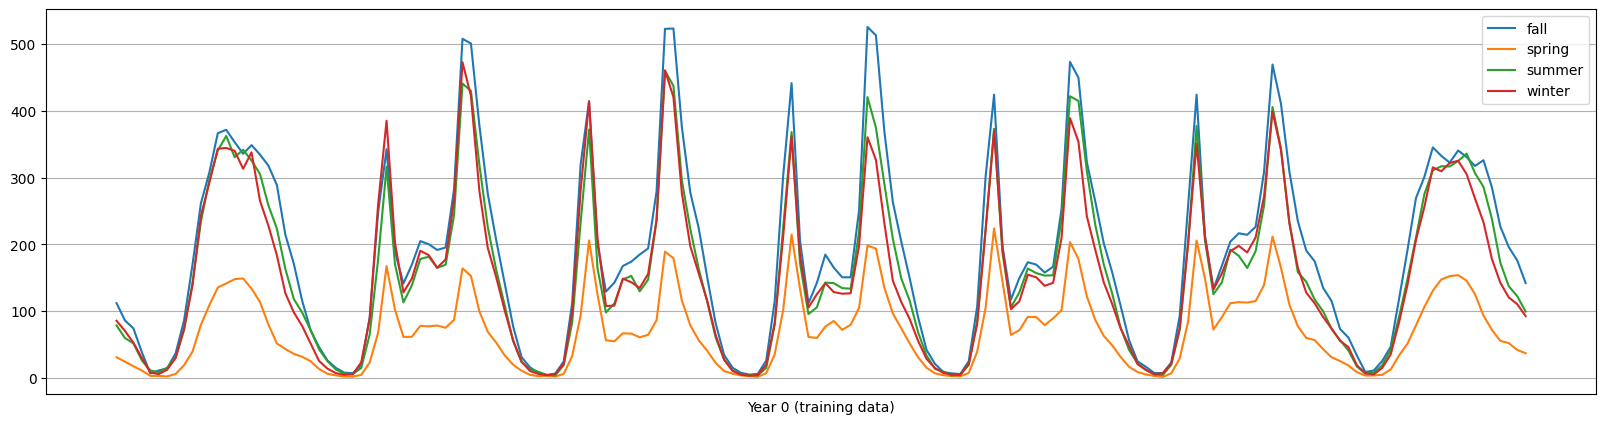

In [210]:
df = bikes[bikes['year'] == 0]
fig,ax = plt.subplots(figsize = (20, 5))
average_bike_rentals = df.groupby(
    ["year", "season", "weekday", "hour"], observed=True
).mean(numeric_only=True)["count"]
average_bike_rentals.groupby(['season'], observed = True).plot(legend = True)
plt.xticks([], [])
plt.xlabel('Year 0 (training data)')
plt.grid();

In [211]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      17379 non-null  category
 1   year        17379 non-null  int64   
 2   month       17379 non-null  int64   
 3   hour        17379 non-null  int64   
 4   holiday     17379 non-null  category
 5   weekday     17379 non-null  int64   
 6   workingday  17379 non-null  category
 7   weather     17379 non-null  category
 8   temp        17379 non-null  float64 
 9   feel_temp   17379 non-null  float64 
 10  humidity    17379 non-null  float64 
 11  windspeed   17379 non-null  float64 
 12  count       17379 non-null  int64   
dtypes: category(4), float64(4), int64(5)
memory usage: 1.3 MB


In [231]:
X = bikes.drop(columns = 'count')
y = bikes['count']
train = bikes[bikes['year'] == 0]
test = bikes[bikes['year'] == 1]
X_train = train.drop(columns = 'count')
y_train = train['count']
X_test = test.drop(columns = 'count')
y_test = test['count']

In [232]:
reg = XGBRegressor(enable_categorical=True)
reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [233]:
reg.score(X_train, y_train)

0.9789959788322449

In [234]:
reg.score(X_test, y_test)

0.6463150978088379

**PROBLEM**

What should we do if we want to improve performance?  See [here](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html#control-overfitting)

### Inspecting Results

- [Partial Dependence Plots](https://scikit-learn.org/stable/modules/partial_dependence.html)
- [Permutation Feature Importance](https://scikit-learn.org/stable/modules/permutation_importance.html)

In [264]:
reg.feature_importances_

array([0.06592979, 0.        , 0.03411739, 0.27398434, 0.01827372,
       0.0154194 , 0.28702936, 0.06249612, 0.08871585, 0.12923817,
       0.01873765, 0.00605831], dtype=float32)

In [265]:
pd.DataFrame({'feature': X_train.columns.tolist(), 'importance': reg.feature_importances_}).sort_values(by = 'importance', ascending = False)

feature  importance
6   workingday    0.287029
3         hour    0.273984
9    feel_temp    0.129238
8         temp    0.088716
0       season    0.065930
7      weather    0.062496
2        month    0.034117
10    humidity    0.018738
4      holiday    0.018274
5      weekday    0.015419
11   windspeed    0.006058
1         year    0.000000

In [235]:
from sklearn.inspection import PartialDependenceDisplay, permutation_importance

In [236]:
X_test.head()

season  year  month  hour  ...   temp  feel_temp humidity windspeed
8645  spring     1      1     0  ...  14.76     18.940     0.66    0.0000
8646  spring     1      1     1  ...  14.76     17.425     0.66    8.9981
8647  spring     1      1     2  ...  13.12     17.425     0.76    0.0000
8648  spring     1      1     3  ...  12.30     16.665     0.81    0.0000
8649  spring     1      1     4  ...  11.48     15.150     0.81    6.0032

[5 rows x 12 columns]

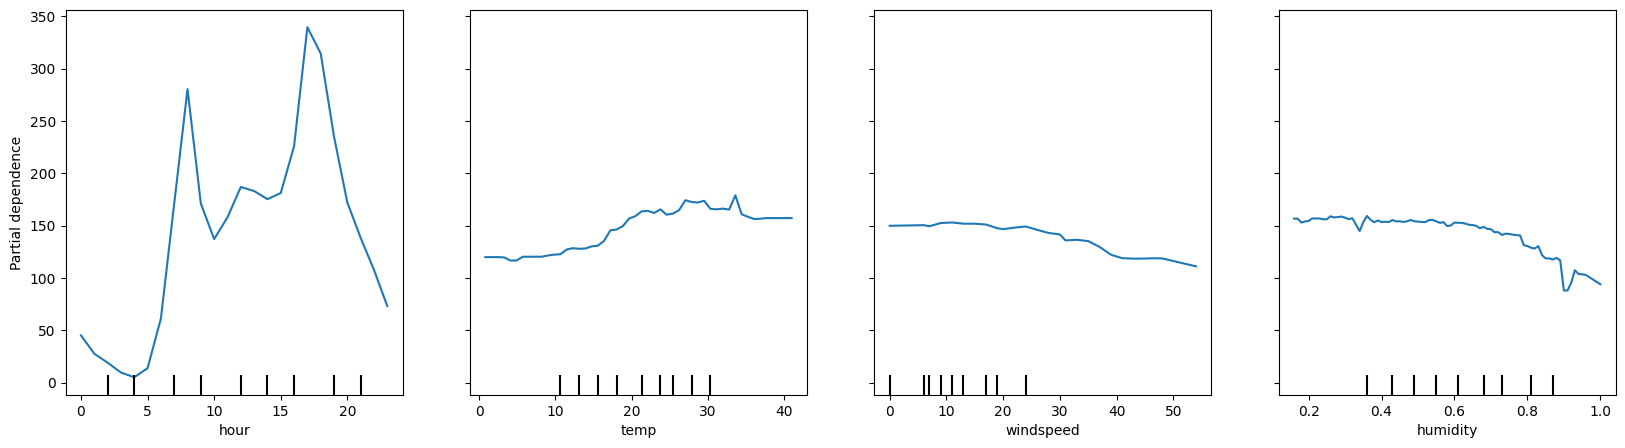

In [237]:
fig, ax = plt.subplots(figsize = (20, 5))
PartialDependenceDisplay.from_estimator(reg, X_test, features = ['hour', 'temp', 'windspeed', 'humidity'],  n_cols = 4,ax = ax)

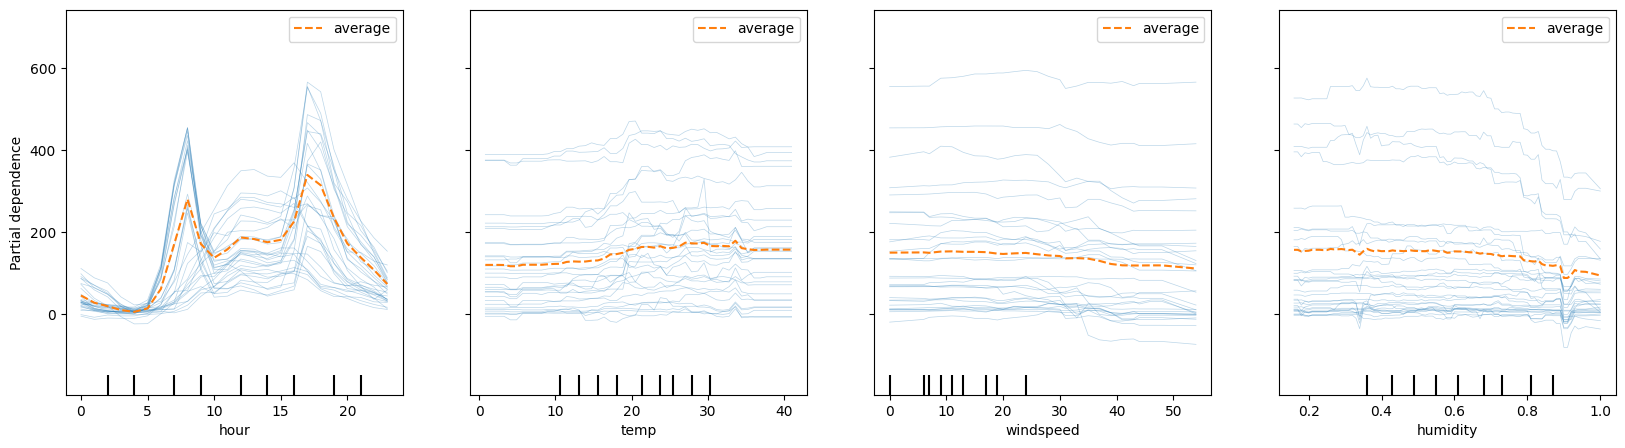

In [238]:
fig, ax = plt.subplots(figsize = (20, 5))
PartialDependenceDisplay.from_estimator(reg, X_test, features = ['hour', 'temp', 'windspeed', 'humidity'],  
                                        kind = 'both',
                                        n_cols = 4,ax = ax,
                                       subsample = 30)

We can also explore two variable PDP plots to understand interactions between features.  Note the wiggles in the ICE plots above with temperature and humidity.

![](images/pdp.png) 

In [243]:
# Slower to plot the 2-way PDP
# PartialDependenceDisplay.from_estimator(reg, X_train, [('temp', 'humidity')], subsample = 50, n_jobs = -1, grid_resolution=20, kind = 'average' )


**Permutation Feature Importance**

Permute individual features while holding others constant to see the effect on target.

In [250]:
results = permutation_importance(reg, X_train, y_train, n_repeats=10)

In [251]:
results

{'importances_mean': array([0.06408446, 0.        , 0.05608611, 1.38907729, 0.00536676,
        0.03095871, 0.26588249, 0.03003684, 0.09342833, 0.06718443,
        0.09206399, 0.01775954]),
 'importances_std': array([0.00146776, 0.        , 0.00142307, 0.02330278, 0.00026406,
        0.00068182, 0.00639445, 0.00058722, 0.00220706, 0.00162217,
        0.00358808, 0.0007023 ]),
 'importances': array([[0.06300265, 0.06402278, 0.06463879, 0.06582814, 0.06204641,
         0.06684893, 0.06517816, 0.06249613, 0.06286907, 0.06391352],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.05552417, 0.05325413, 0.05561483, 0.05599797, 0.05715764,
         0.05666196, 0.05552161, 0.05509174, 0.05717289, 0.05886412],
        [1.39215404, 1.38278419, 1.39891392, 1.43035001, 1.39482099,
         1.3678748 , 1.39885134, 1.41269845, 1.36795563, 1.34436959],
        [0.00556594, 0.00533265, 0.00586772, 0.005

<Axes: >

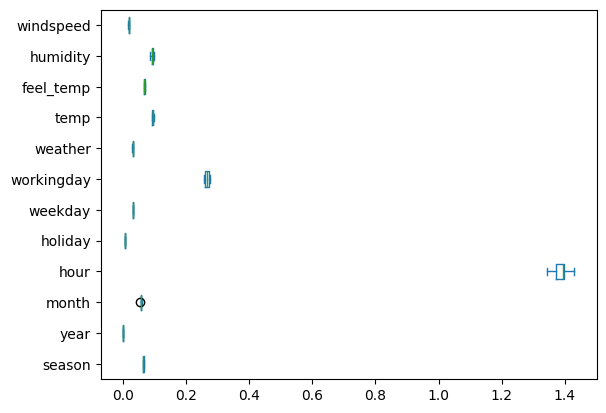

In [253]:
pd.DataFrame(results['importances'], index = X_train.columns.tolist()).T.plot(kind = 'box', vert = False)

In [263]:
pd.DataFrame(results['importances_mean'], index = X_train.columns.tolist()).sort_values(0, ascending = False)

0
hour        1.389077
workingday  0.265882
temp        0.093428
humidity    0.092064
feel_temp   0.067184
season      0.064084
month       0.056086
weekday     0.030959
weather     0.030037
windspeed   0.017760
holiday     0.005367
year        0.000000

### Comparing Boosted Models

Returning to the food marketing data from last class:

- Can you tune a boosted model to do better than the baseline and optimize towards precision?
- What features were important to making these predictions and how would you suggest targeting future customers?

In [272]:
food_marketing = pd.read_csv('https://raw.githubusercontent.com/jfkoehler/nyu_bootcamp_fa25/refs/heads/main/data/food_data.csv')

In [273]:
food_marketing.head()

ID  Year_Birth   Education  ... Z_CostContact  Z_Revenue  Response
0  5524        1957  Graduation  ...             3         11         1
1  2174        1954  Graduation  ...             3         11         0
2  4141        1965  Graduation  ...             3         11         0
3  6182        1984  Graduation  ...             3         11         0
4  5324        1981         PhD  ...             3         11         0

[5 rows x 29 columns]

In [274]:
food_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [275]:
food_marketing[['Education', 'Marital_Status']] = food_marketing[['Education', 'Marital_Status']].astype('category')

In [276]:
food_marketing.drop(columns = 'Dt_Customer', inplace = True)

In [277]:
X = food_marketing.drop(columns = 'Response')
y = food_marketing['Response']

In [278]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=10)

#### PROBLEM

Below, a dataset around an email campaign for sales is loaded and displayed.  Explore the description of the task [here](https://blog.minethatdata.com/2008/03/minethatdata-e-mail-analytics-and-data.html).  Consider a strategy for model building and evaluation.  

In [62]:
# !pip install scikit-uplift

In [63]:
from sklift.datasets import fetch_hillstrom

In [64]:
dataset = fetch_hillstrom(target_col='conversion')
data, target, treatment = dataset.data, dataset.target, dataset.treatment

In [59]:
data.head()

recency history_segment  history  mens  womens   zip_code  newbie channel
0       10  2) $100 - $200   142.44     1       0  Surburban       0   Phone
1        6  3) $200 - $350   329.08     1       1      Rural       1     Web
2        7  2) $100 - $200   180.65     0       1  Surburban       1     Web
3        9  5) $500 - $750   675.83     1       0      Rural       1     Web
4        2    1) $0 - $100    45.34     1       0      Urban       0     Web

In [60]:
target.head()

0    0
1    0
2    0
3    0
4    0
Name: conversion, dtype: int64

In [61]:
treatment.head()

0    Womens E-Mail
1        No E-Mail
2    Womens E-Mail
3      Mens E-Mail
4    Womens E-Mail
Name: segment, dtype: object